In [1]:
import torch

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [5]:
from transformers import DataCollatorForLanguageModeling


In [6]:
from datasets import Dataset

In [7]:
from transformers import Trainer, TrainingArguments

In [23]:
import re

In [24]:
import pandas as pd
import numpy as np


In [8]:
def tokenize_function(data):
    result = tokenizer(data)
    return result


In [9]:
def concat_chunk_dataset(data):
    chunk_size = 128
    
    # drop the last chunk if is smaller than the chunk size
    total_length = len(data["input_ids"])

    # split the concatenated sentences into chunks using the total length
    result = {k: [t[i: i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in data.items()}
    

    return pd.DataFrame(result)



In [27]:
def fill_masks(sentence, targets):
        new_sentence = sentence
        for target in targets:
            new_sentence = re.sub('MASK',target,new_sentence, count=1)
        #print("FILLED MASK:", new_sentence)
        return new_sentence



def read_file(filename):
    df = pd.read_csv(filename)
    df['Target_Stereotypical'] = df['Target_Stereotypical'].apply(lambda x: x.replace("'", "").replace('[', '').replace(']','').split(','))
    df['Target_Anti-Stereotypical'] = df['Target_Anti-Stereotypical'].apply(lambda x: x.replace("'", "").replace('[', '').replace(']','').split(','))
    df['Stereotypical'] = df.apply(lambda x: fill_masks(x['Sentence'],x['Target_Stereotypical']),axis=1)
    df['Anti-Stereotypical'] = df.apply(lambda x: fill_masks(x['Sentence'],x['Target_Anti-Stereotypical']),axis=1)
    return df

def calculate_aul(model, sentence, log_softmax):
    '''
    Given token ids of a sequence, return the averaged log probability of
    unmasked sequence (AULA or AUL).
    '''
    tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)

    # Get the token IDs and attention mask
    input_ids = tokens['input_ids'].to('mps')
    output = model(input_ids, output_hidden_states=True)
    logits = output.logits.squeeze(0)
    log_probs = log_softmax(logits)
    input_ids = input_ids.view(-1, 1).detach()
    token_log_probs = log_probs.gather(1, input_ids)[1:-1]
    sentence_log_prob = torch.mean(token_log_probs)
    score = sentence_log_prob.item()

    hidden_states = output.hidden_states[-1][:,1:-1].cpu()
    hidden_state = torch.mean(hidden_states, 1).detach().numpy()

    return score, hidden_state


def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


In [10]:
fir_df = pd.read_csv("13225_13225097_fir.csv")

In [11]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased', return_tensors='pt', padding=True)


In [12]:
tokens = fir_df["fir_text"].apply(lambda x: tokenize_function(x))

Token indices sequence length is longer than the specified maximum sequence length for this model (909 > 512). Running this sequence through the model will result in indexing errors


In [13]:
processed_dataset = pd.concat(tokens.apply(lambda x : concat_chunk_dataset(x)).tolist()).drop_duplicates(subset="input_ids").reset_index(drop=True)

In [14]:
data_collator = DataCollatorForLanguageModeling(tokenizer = tokenizer, mlm_probability = .15)

In [15]:
fir_ds = Dataset.from_pandas(processed_dataset)

In [ ]:
model = AutoModelForMaskedLM.from_pretrained("bert-base-multilingual-uncased")

In [28]:
log_softmax = torch.nn.LogSoftmax(dim=1)

In [29]:
caste_df = read_file(filename="../data/Caste.csv")

In [45]:
train_size = 100
test_size = int(0.2 * train_size)

results = {}

k = 0

while k < 30:
    
    curr_seed = np.random.randint(100)

    downsampled_dataset = fir_ds.train_test_split(train_size=train_size, test_size=test_size, seed=curr_seed)


    training_args = TrainingArguments(
        "bert-base-multilingual-uncased-finetuned",
        evaluation_strategy = "epoch",
        num_train_epochs = 3,
        learning_rate=2e-5,
        weight_decay=0.01,
        push_to_hub=False,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=downsampled_dataset["train"],
        eval_dataset=downsampled_dataset["test"],
        data_collator=data_collator,
    )

    trainer.train()

    eval_results = trainer.evaluate()

    eval_model = trainer.model


    # discrimination analysis
    stereo_inputs = [i for i in caste_df['Stereotypical']]
    antistereo_inputs = [i for i in caste_df['Anti-Stereotypical']]
    
    stereo_scores = []
    antistereo_scores = []
    stereo_embes = []
    antistereo_embes = []
    
    for i in stereo_inputs:
        stereo_score, stereo_hidden_state = calculate_aul(eval_model, i, log_softmax)
        stereo_scores.append(stereo_score)
        stereo_embes.append(stereo_hidden_state)
    
    for j in antistereo_inputs:
        antistereo_score, antistereo_hidden_state = calculate_aul(eval_model, j, log_softmax)
        antistereo_scores.append(antistereo_score)
        antistereo_embes.append(antistereo_hidden_state)
    
    stereo_scores = np.array(stereo_scores)
    stereo_scores = stereo_scores.reshape([-1, 1])
    antistereo_scores = np.array(antistereo_scores)
    antistereo_scores = antistereo_scores.reshape([1, -1])
    bias_scores = stereo_scores > antistereo_scores
    
    stereo_embes = np.concatenate(stereo_embes)
    antistereo_embes = np.concatenate(antistereo_embes)
    weights = cos_sim(stereo_embes, antistereo_embes.T)
    
    weighted_bias_scores = bias_scores * weights
    bias_score = np.sum(weighted_bias_scores) / np.sum(weights)
    print('bias score (emb):', round(bias_score * 100, 2))

    results[k] = {"bias_score":bias_score}

    k += 1
    

    
    

Epoch,Training Loss,Validation Loss
1,No log,4.012292
2,No log,3.044393
3,No log,3.356153


bias score (emb): 60.85


Epoch,Training Loss,Validation Loss
1,No log,4.024426
2,No log,3.056776
3,No log,3.362688


bias score (emb): 60.78


Epoch,Training Loss,Validation Loss
1,No log,4.029944
2,No log,3.062006
3,No log,3.408699


bias score (emb): 61.17


Epoch,Training Loss,Validation Loss
1,No log,3.995325
2,No log,3.030771
3,No log,3.378663


bias score (emb): 60.81


Epoch,Training Loss,Validation Loss
1,No log,4.100130
2,No log,3.105692
3,No log,3.289330


bias score (emb): 60.17


Epoch,Training Loss,Validation Loss
1,No log,3.842653
2,No log,3.002010
3,No log,3.406016


bias score (emb): 60.53


Epoch,Training Loss,Validation Loss
1,No log,3.870047
2,No log,3.020395
3,No log,3.400510


bias score (emb): 60.74


Epoch,Training Loss,Validation Loss
1,No log,3.841187
2,No log,3.000535
3,No log,3.357008


bias score (emb): 60.0


Epoch,Training Loss,Validation Loss
1,No log,3.956818
2,No log,3.086780
3,No log,3.392299


bias score (emb): 60.02


Epoch,Training Loss,Validation Loss
1,No log,4.055297
2,No log,3.104088
3,No log,3.424273


bias score (emb): 59.91


Epoch,Training Loss,Validation Loss
1,No log,4.095629
2,No log,3.135188
3,No log,3.415255


bias score (emb): 59.85


Epoch,Training Loss,Validation Loss
1,No log,4.102582
2,No log,3.119590
3,No log,3.421136


bias score (emb): 60.12


Epoch,Training Loss,Validation Loss
1,No log,4.115332
2,No log,3.127640
3,No log,3.462230


bias score (emb): 60.4


Epoch,Training Loss,Validation Loss
1,No log,4.130271
2,No log,3.110010
3,No log,3.417049


bias score (emb): 60.34


Epoch,Training Loss,Validation Loss
1,No log,4.118200
2,No log,3.115600
3,No log,3.423749


bias score (emb): 60.35


Epoch,Training Loss,Validation Loss
1,No log,4.122424
2,No log,3.121382
3,No log,3.425247


bias score (emb): 60.48


Epoch,Training Loss,Validation Loss
1,No log,4.117776
2,No log,3.118419
3,No log,3.433974


bias score (emb): 60.47


Epoch,Training Loss,Validation Loss
1,No log,4.118925
2,No log,3.111454
3,No log,3.438003


bias score (emb): 60.53


Epoch,Training Loss,Validation Loss
1,No log,4.117962
2,No log,3.121847
3,No log,3.442008


bias score (emb): 60.49


Epoch,Training Loss,Validation Loss
1,No log,4.121507
2,No log,3.112751
3,No log,3.440483


bias score (emb): 60.55


In [50]:
bias_scores = pd.DataFrame(results).T

### vis

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

/var/folders/_b/f9nc4qh95g3_n_rd2529n2xc0000gn/T/ipykernel_59320/1212699462.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axvline(x=bias_scores.mean()[0],color="blue")
/var/folders/_b/f9nc4qh95g3_n_rd2529n2xc0000gn/T/ipykernel_59320/1212699462.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(bias_scores.mean()[0], 0.7, 'mbert FIR AUL', color='blue', ha='right', va='top', rotation=90, transform=ax.get_xaxis_transform())


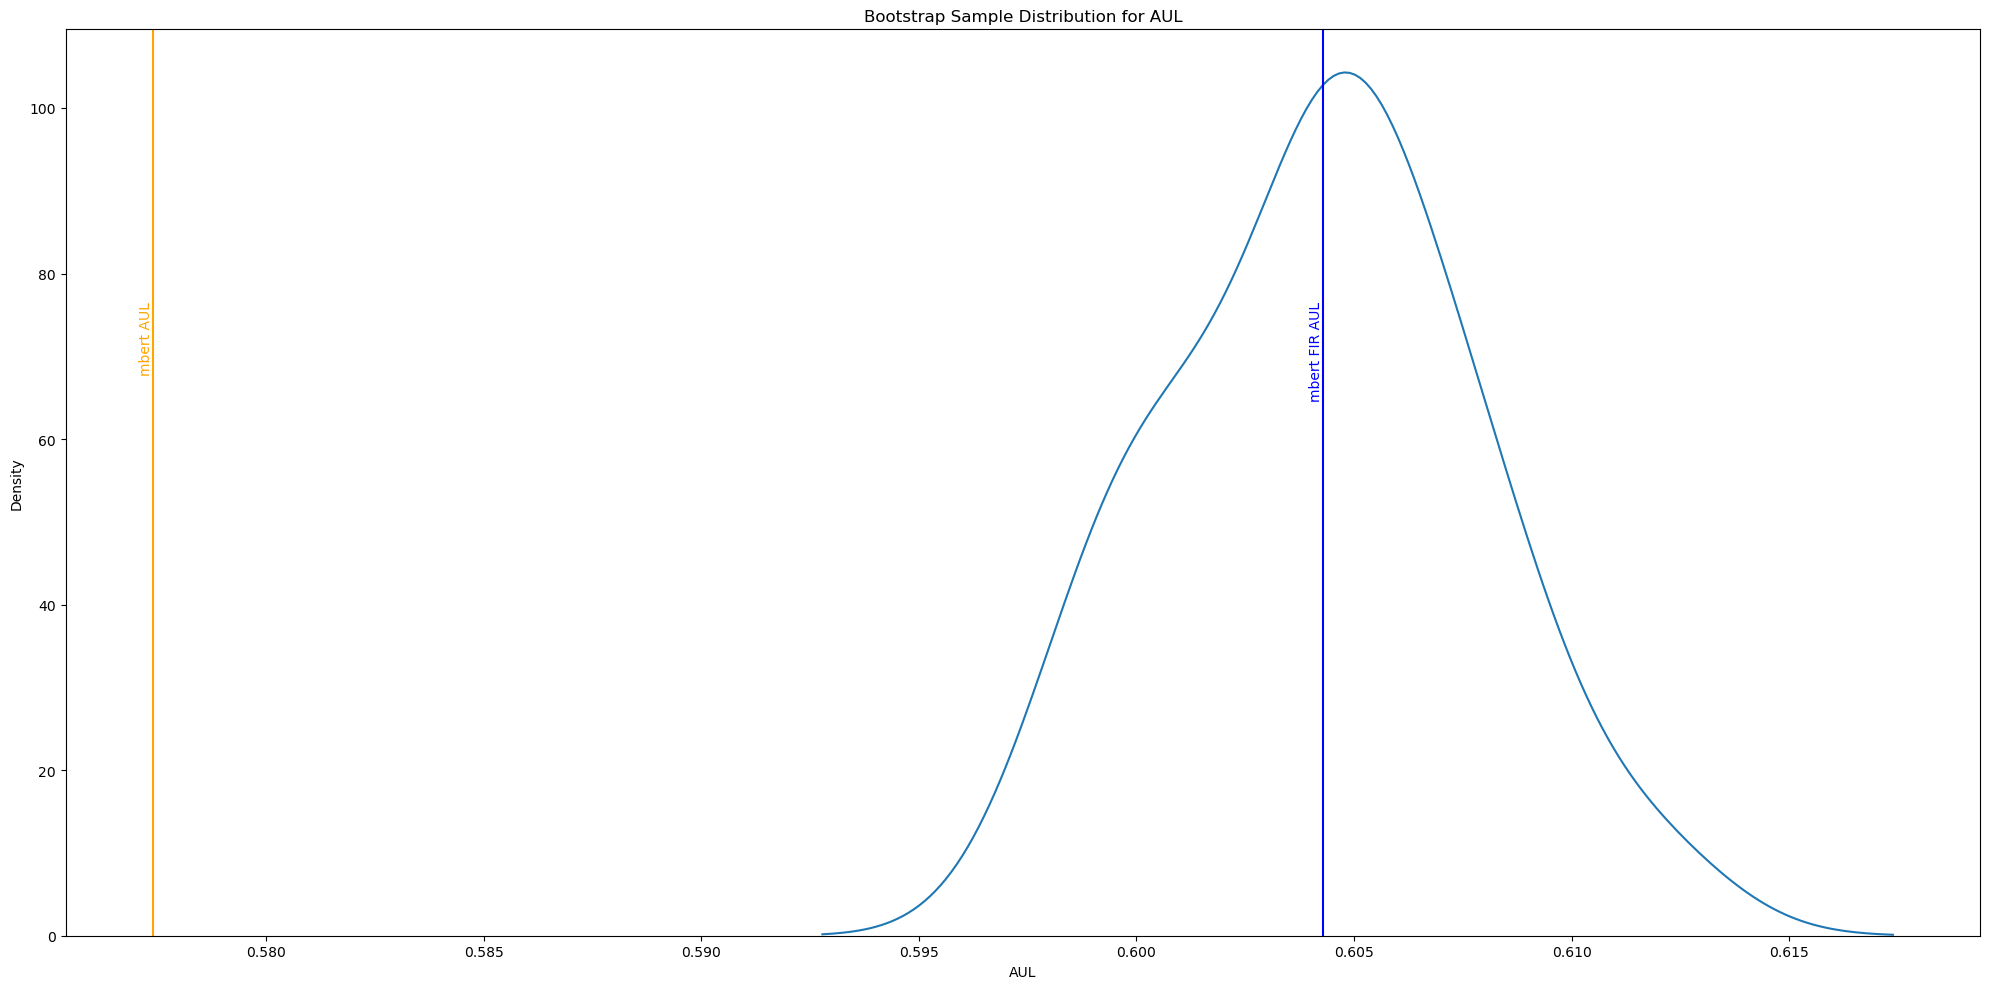

In [84]:
fig, ax = plt.subplots(figsize=(20,10))

sns.kdeplot(data=bias_scores, ax=ax, legend=False)
ax.axvline(x=0.5774,color="orange")
ax.axvline(x=bias_scores.mean()[0],color="blue")
ax.text(bias_scores.mean()[0], 0.7, 'mbert FIR AUL', color='blue', ha='right', va='top', rotation=90, transform=ax.get_xaxis_transform())
ax.text(0.5774, 0.7, 'mbert AUL', color='orange', ha='right', va='top', rotation=90,
            transform=ax.get_xaxis_transform())
ax.set_title("Bootstrap Sample Distribution for AUL")
ax.set_xlabel("AUL")

plt.tight_layout()
plt.savefig("aul_bootstrap_mbert_plot.png",dpi=100)

In [82]:
100*(bias_scores.mean()[0] - 0.5774)

/var/folders/_b/f9nc4qh95g3_n_rd2529n2xc0000gn/T/ipykernel_59320/3328811206.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  100*(bias_scores.mean()[0] - 0.5774)


2.688029298782346